In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import aesara.tensor as at

import cobra
import os
os.getcwd()

from src import BMCA, util
import emll


WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
r = te.loada('data/interim/Antimony/BIOMD0000000064_e_cobra.ant')
r.getSBML()

'<?xml version="1.0" encoding="UTF-8"?>\n<sbml xmlns="http://www.sbml.org/sbml/level3/version1/core" level="3" version="1">\n  <model metaid="__main" id="__main">\n    <listOfCompartments>\n      <compartment id="extracellular" spatialDimensions="3" constant="true"/>\n      <compartment id="cytosol" spatialDimensions="3" constant="true"/>\n    </listOfCompartments>\n    <listOfSpecies>\n      <species id="GLCi" compartment="cytosol" initialConcentration="1" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>\n      <species id="G6P" compartment="cytosol" initialConcentration="1" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>\n      <species id="F6P" compartment="cytosol" initialConcentration="1" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>\n      <species id="F16P" compartment="cytosol" initialConcentration="1" hasOnlySubstanceUnits="false" boundaryCondition="false" constant="false"/>\n      <species id="T

In [3]:
model = cobra.io.read_sbml_model("data/interim/BIOMD64_cobra_sbml.xml")

Model does not contain SBML fbc package information.


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-19


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

Generating data for running through the pipeline.

In [4]:
data_file = 'data/interim/generated_data/EtOHcompilation.csv'
# data_file = 'data/interim/generated_data/EtOHcompilation_small.csv'
data = pd.read_csv(data_file)

In [5]:
from src import BMCA, util
import tellurium as te

Teusink_ant = 'data/interim/Antimony/BIOMD0000000064_e.ant'
data_file = 'data/interim/generated_data/EtOHcompilation.csv'

r = te.loada(Teusink_ant)
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

In [ ]:
import numpy as np
import pymc as pm
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64.Ey.to_numpy(), name='Ey'))

    trace_prior = pm.sample_prior_predictive(samples=1000)

In [18]:
with pymc_model:
    
    # e_obs = pm.Normal('e_obs', mu=BIOMD64.en.T, sigma=0.1)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64.xn.T)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64.yn.T)

    likelihood = pm.Deterministic('vn', (np.ones((17,30)) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64.vn.squeeze().T)
pymc_model.free_RVs

[Ex_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ex_capacity_entries ~ Laplace(0, 0.01),
 Ey_kinetic_entries ~ SkewNormal(0, 1, 5),
 Ey_capacity_entries ~ Laplace(0, 0.01),
 chi_obs ~ N(<constant>, 0.1),
 y_obs ~ N(<constant>, 0.1)]

In [19]:
N_ITERATIONS = 50000
with pymc_model:
    advi = pm.ADVI()
    tracker = pm.callbacks.Tracker(
        mean = advi.approx.mean.eval,
        std = advi.approx.std.eval
    )
    approx = advi.fit(
        n=       N_ITERATIONS, 
        callbacks = [tracker],
        obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
        total_grad_norm_constraint=0.7,
        obj_n_mc=1)
    
    trace_vi = approx.sample(draws=1000, random_seed=1) 
    ppc_vi = pm.sample_posterior_predictive(trace_vi, random_seed=1)
    

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 135.24
Sampling: [v_hat_obs]


In [20]:
Ex_trace = (trace_vi['posterior']['Ex']).to_numpy().squeeze().transpose(1, 2, 0)

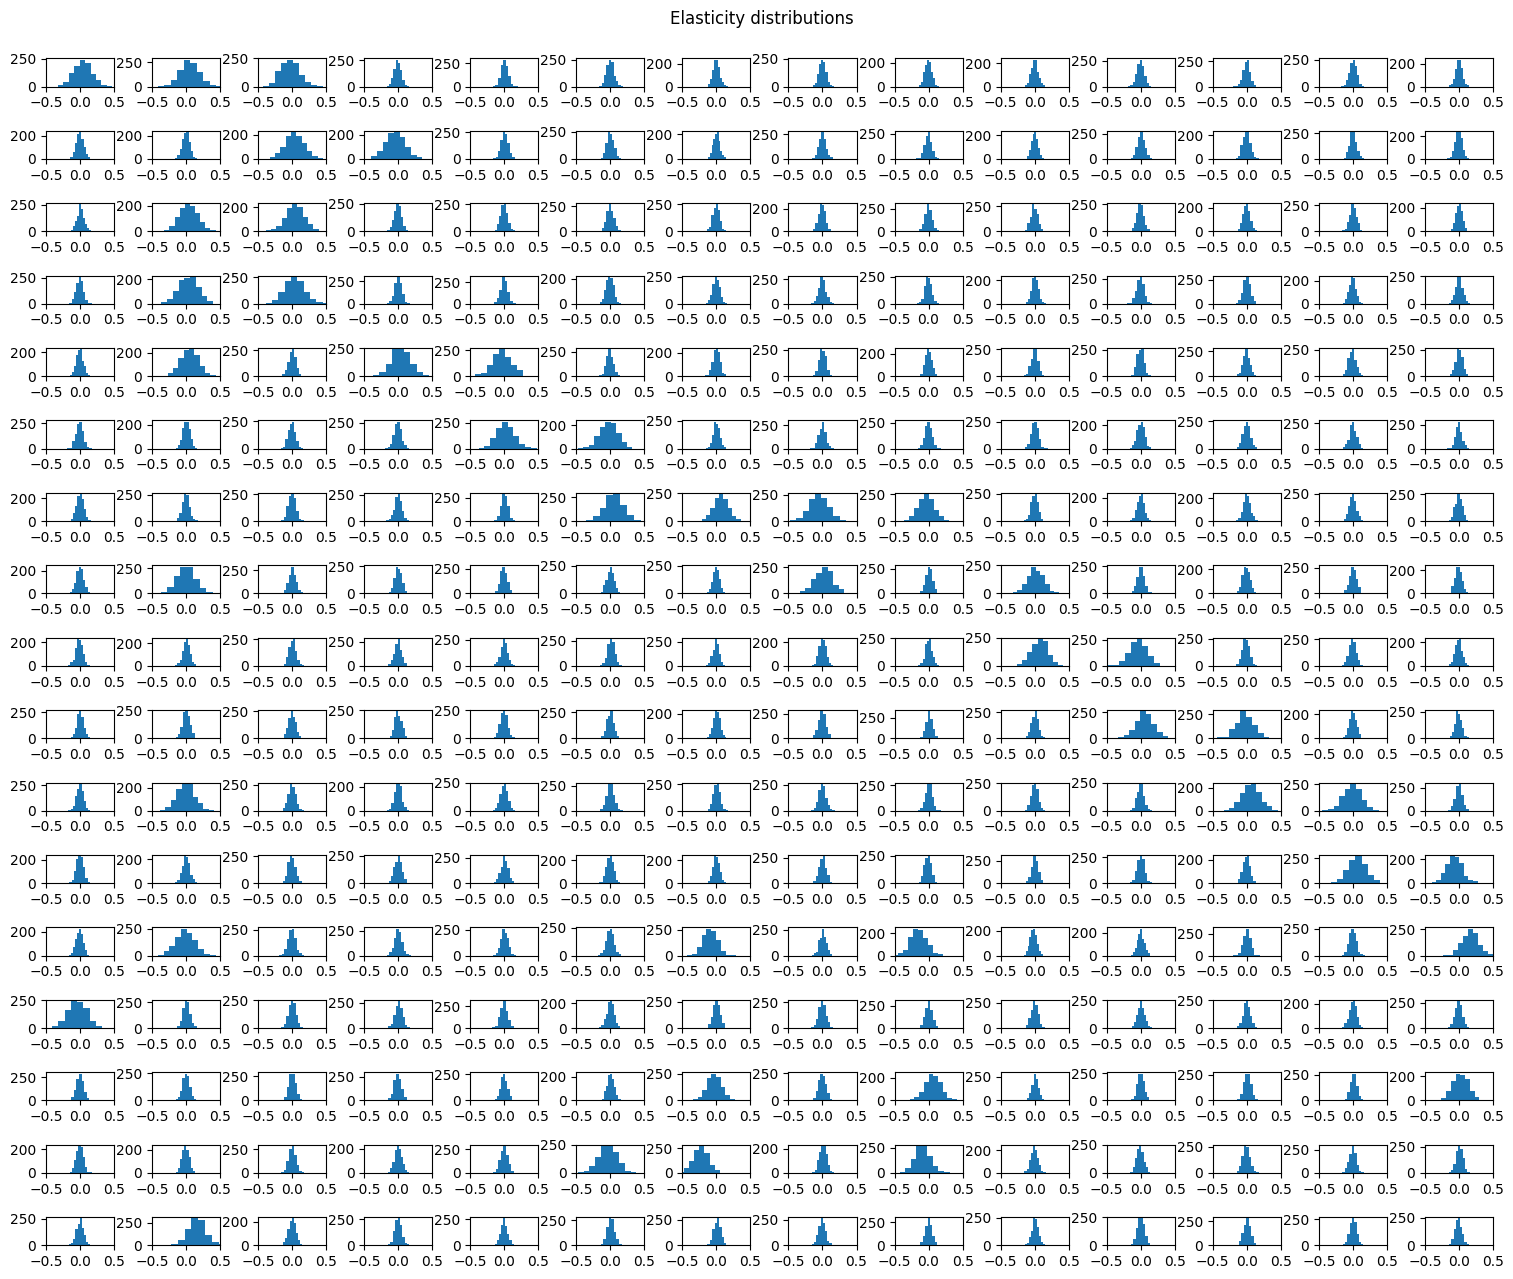

In [34]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,14, figsize=(15, 13)) 

fig.suptitle('Elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(14):
    axs[i,ii].hist(Ex_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

As you can see, all the distributions are unimodal

In [22]:
Ex_peaks=[]

for i in range(Ex_trace.shape[0]):
    for ii in range(Ex_trace.shape[1]):
        Ex_peaks.append(np.percentile(Ex_trace[i,ii,:],50))


In [23]:
# these are the elasticity posteriors from Bayesian inference
x = np.array(Ex_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
x[abs(x) < 0.01] = 0

x = x.reshape((17,14))
pd.DataFrame(x, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds())

,GLCi,G6P,F6P,F16P,TRIO,BPG,P3G,P2G,PEP,PYR,ACE,P,NAD,NADH
vGLK,0.044017,0.051021,-0.035646,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vPGI,0.000000,0.000000,0.035666,-0.047996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vGLYCO,0.000000,0.041091,0.047328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vTreha,0.000000,0.036001,0.034908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vPFK,0.000000,0.048757,0.000000,0.034582,-0.040596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vALD,0.000000,0.000000,0.000000,0.000000,0.014076,-0.025156,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vGAPDH,0.000000,0.000000,0.000000,0.000000,0.000000,0.054505,0.066072,-0.052291,-0.023013,0.000000,0.000000,0.000000,0.000000,0.000000
vPGK,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021655,0.012577,0.011802,0.000000,0.000000,0.000000,0.000000
vPGM,0.000000,0.000000,0.000000,0.000000,0.000000,0.012560,0.000000,0.000000,0.000000,0.079463,-0.035714,-0.013490,0.000000,0.000000
vENO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011718,0.000000,0.064501,-0.027677,0.000000,0.000000


In [24]:
Ey_trace = (trace_vi['posterior']['Ey']).to_numpy().squeeze().transpose(1, 2, 0)
Ey_trace.shape

(17, 5, 1000)

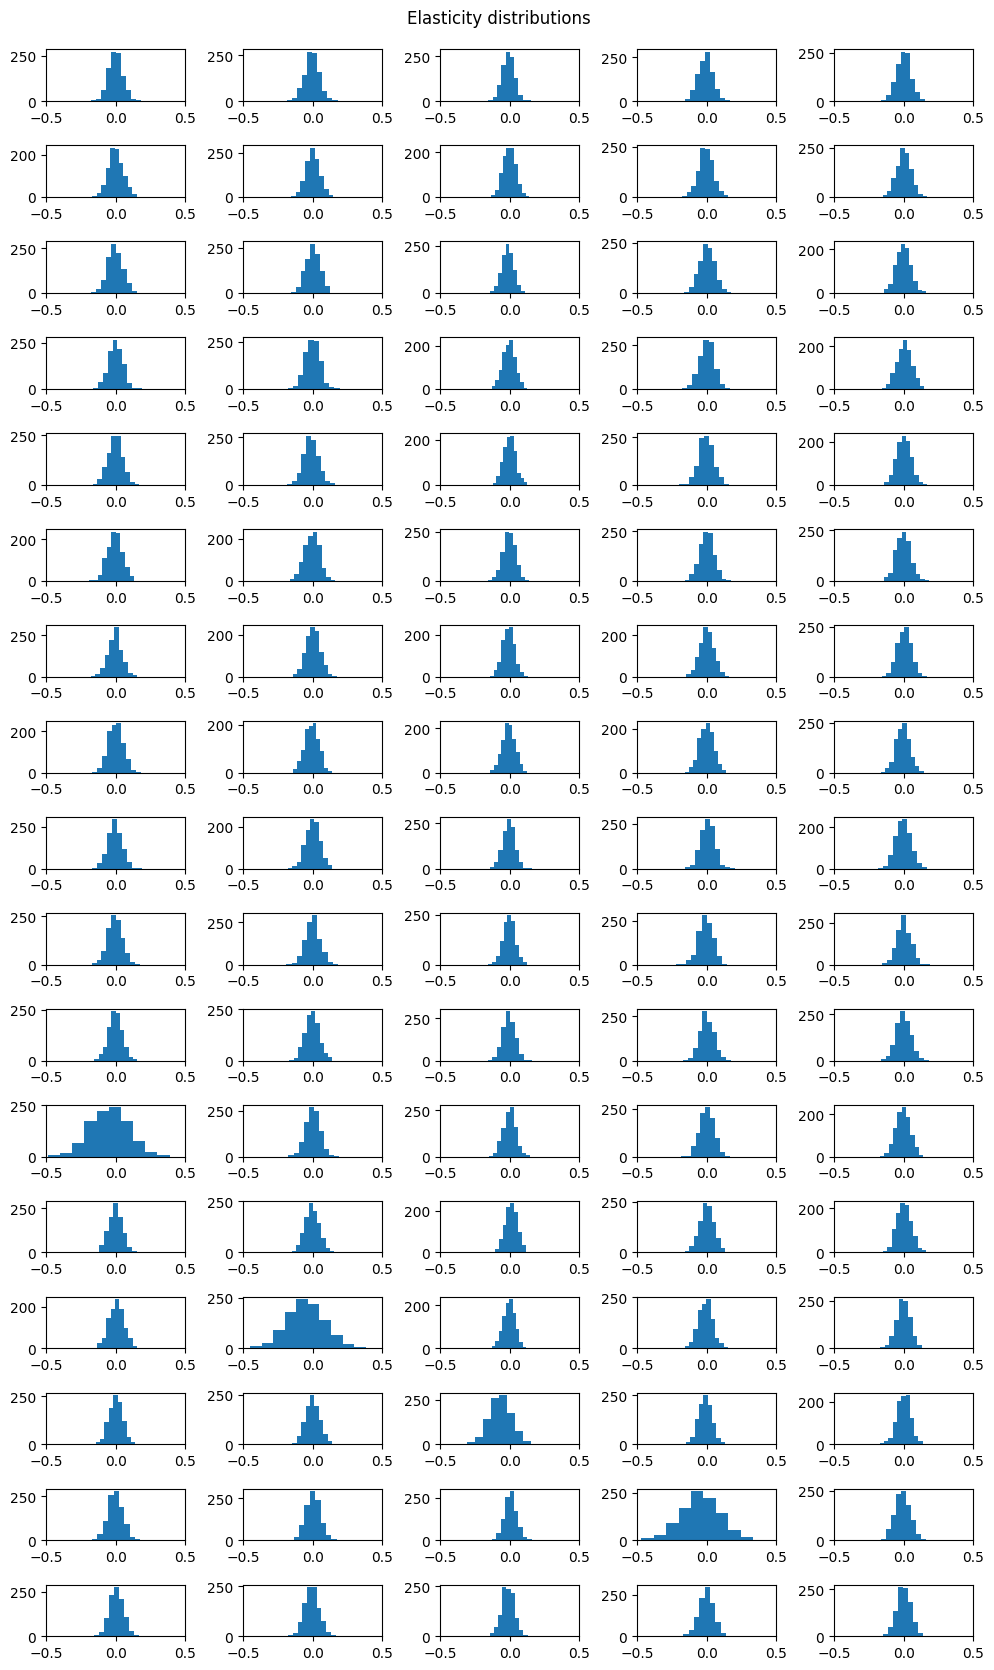

In [35]:
# create a subplot that is (17,14)
fig, axs = plt.subplots(17,5, figsize=(10, 17)) 

fig.suptitle('Elasticity distributions\n')
fig.tight_layout()

for i in range(17):
  for ii in range(5):
    axs[i,ii].hist(Ey_trace[i,ii,:])
    axs[i,ii].set_xlim([-0.5,0.5])

In [26]:
Ey_peaks=[]

for i in range(Ey_trace.shape[0]):
    for ii in range(Ey_trace.shape[1]):
        Ey_peaks.append(np.percentile(Ey_trace[i,ii,:],50))


In [27]:
# elasticities from Bayesian inf posteriors

y = np.array(Ey_peaks)
# 0 out all magnitudes that have less than a magnitude of 0.01
y[abs(y) < 0.01] = 0

y = y.reshape((17,5))
pd.DataFrame(y, index=r.getReactionIds(), columns=r.getBoundarySpeciesIds())

,CO2,GLCo,ETOH,GLY,F26BP
vGLK,0.000000,0.000000,0.000000,0.000000,0.0
vPGI,0.000000,0.000000,0.000000,0.000000,0.0
vGLYCO,0.000000,0.000000,-0.012199,0.000000,0.0
vTreha,0.000000,0.000000,0.000000,0.000000,0.0
vPFK,0.000000,-0.012438,0.000000,0.000000,0.0
vALD,0.000000,0.000000,0.000000,0.000000,0.0
vGAPDH,0.000000,0.000000,0.000000,0.000000,0.0
vPGK,0.000000,0.000000,0.000000,0.000000,0.0
vPGM,0.000000,0.000000,0.000000,0.000000,0.0
vENO,0.000000,0.000000,0.000000,0.000000,0.0


In [28]:
a = data['ETOH']/50
a.drop(a.index[0],inplace=True)

In [36]:
d = np.diag(BIOMD64.v_star)@(np.ones(BIOMD64.N.shape[1]).reshape((-1,1)) + x@(BIOMD64.xn).T + y@(BIOMD64.yn).T)
d_df = pd.DataFrame(d) #, index=r.getReactionIds(), columns=a.round(2).values) 

In [38]:
# d_df is the flux calculated using the Bayesian inference posteriors for elasticity

d_df.index = r.getReactionIds()
d_df.columns = a.round(2).values
d_df = d_df.divide(d_df[1.00], axis=0)
d_df

,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,1.021419,1.013121,1.008595,1.005827,1.004031,1.002824,1.001995,1.001417,1.001010,1.000722,1.000518,1.000371,1.000267,1.000191,1.0,0.999810,0.999737,0.999635,0.999494,0.999301,0.999034,0.998669,0.998172,0.997499,0.996597,0.995402,0.993841,0.991836,0.989309,0.986184
vPGI,1.002446,1.001287,1.000785,1.000511,1.000344,1.000237,1.000165,1.000116,1.000083,1.000059,1.000042,1.000030,1.000022,1.000015,1.0,0.999985,0.999979,0.999971,0.999960,0.999944,0.999923,0.999895,0.999857,0.999806,0.999740,0.999654,0.999548,0.999419,0.999269,0.999102
vGLYCO,1.035443,1.020553,1.013156,1.008807,1.006045,1.004214,1.002966,1.002102,1.001496,1.001069,1.000765,1.000548,1.000394,1.000283,1.0,0.999720,0.999612,0.999462,0.999256,0.998971,0.998581,0.998048,0.997323,0.996348,0.995049,0.993341,0.991134,0.988341,0.984887,0.980718
vTreha,1.016891,1.009890,1.006340,1.004244,1.002912,1.002029,1.001428,1.001012,1.000720,1.000514,1.000368,1.000264,1.000189,1.000136,1.0,0.999865,0.999813,0.999742,0.999642,0.999506,0.999318,0.999062,0.998714,0.998246,0.997624,0.996807,0.995754,0.994424,0.992784,0.990812
vPFK,1.035148,1.020712,1.013306,1.008916,1.006121,1.004266,1.003003,1.002128,1.001514,1.001081,1.000774,1.000555,1.000398,1.000286,1.0,0.999717,0.999608,0.999456,0.999247,0.998960,0.998565,0.998026,0.997295,0.996311,0.995001,0.993282,0.991069,0.988278,0.984850,0.980755
vALD,0.985250,0.991582,0.994650,0.996431,0.997556,0.998298,0.998803,0.999152,0.999397,0.999569,0.999692,0.999779,0.999841,0.999886,1.0,1.000113,1.000156,1.000216,1.000300,1.000414,1.000571,1.000785,1.001076,1.001468,1.001989,1.002673,1.003556,1.004671,1.006049,1.007710
vGAPDH,1.069654,1.040722,1.026296,1.017729,1.012234,1.008561,1.006044,1.004291,1.003060,1.002187,1.001567,1.001124,1.000807,1.000580,1.0,0.999425,0.999203,0.998895,0.998470,0.997883,0.997077,0.995972,0.994467,0.992429,0.989694,0.986065,0.981309,0.975169,0.967369,0.957608
vPGK,1.009383,1.005187,1.003209,1.002098,1.001416,1.000975,1.000680,1.000479,1.000340,1.000242,1.000173,1.000124,1.000089,1.000064,1.0,0.999937,0.999913,0.999880,0.999834,0.999771,0.999685,0.999569,0.999413,0.999205,0.998935,0.998591,0.998166,0.997662,0.997098,0.996515
vPGM,1.041297,1.023181,1.014599,1.009684,1.006609,1.004589,1.003223,1.002280,1.001621,1.001157,1.000827,1.000593,1.000425,1.000305,1.0,0.999698,0.999581,0.999420,0.999197,0.998891,0.998472,0.997899,0.997124,0.996083,0.994702,0.992897,0.990581,0.987674,0.984117,0.979876
vENO,1.012740,1.008131,1.005429,1.003721,1.002591,1.001823,1.001292,1.000920,1.000657,1.000470,1.000337,1.000242,1.000174,1.000125,1.0,0.999876,0.999828,0.999762,0.999670,0.999543,0.999368,0.999129,0.998801,0.998356,0.997757,0.996959,0.995908,0.994548,0.992820,0.990666


In [39]:
# get the real values
real_values = data[[i for i in data.columns if 'v_' in i]]
rel_real_values = real_values.div(real_values.iloc[0])
rel_real_values.drop(rel_real_values.index[0], inplace=True)
rel_real_values.columns = r.getReactionIds()
rel_real_values = rel_real_values.transpose()
rel_real_values.columns = a.round(2).values
rel_real_values


,0.28,0.48,0.63,0.73,0.81,0.86,0.90,0.93,0.95,0.96,0.97,0.98,0.99,0.99,1.00,1.01,1.01,1.02,1.03,1.04,1.05,1.07,1.10,1.14,1.19,1.27,1.37,1.52,1.72,2.00
vGLK,1.013158,1.009094,1.006402,1.004547,1.003245,1.002322,1.001665,1.001195,1.000858,1.000617,1.000444,1.000319,1.000230,1.000165,1.0,0.999835,0.999771,0.999682,0.999558,0.999387,0.999149,0.998819,0.998363,0.997732,0.996860,0.995658,0.994002,0.991724,0.988587,0.984251
vPGI,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGLYCO,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vTreha,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
vPFK,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vALD,1.014996,1.010364,1.007296,1.005182,1.003698,1.002646,1.001897,1.001362,1.000978,1.000703,1.000506,1.000364,1.000262,1.000188,1.0,0.999812,0.999739,0.999638,0.999497,0.999301,0.999030,0.998655,0.998135,0.997415,0.996422,0.995052,0.993165,0.990568,0.986993,0.982052
vGAPDH,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGK,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vPGM,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890
vENO,1.060226,1.039023,1.026441,1.018319,1.012855,1.009095,1.006468,1.004616,1.003303,1.002367,1.001698,1.001220,1.000877,1.000630,1.0,0.999373,0.999130,0.998793,0.998327,0.997682,0.996791,0.995565,0.993883,0.991584,0.988462,0.984252,0.978626,0.971185,0.961460,0.948890


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

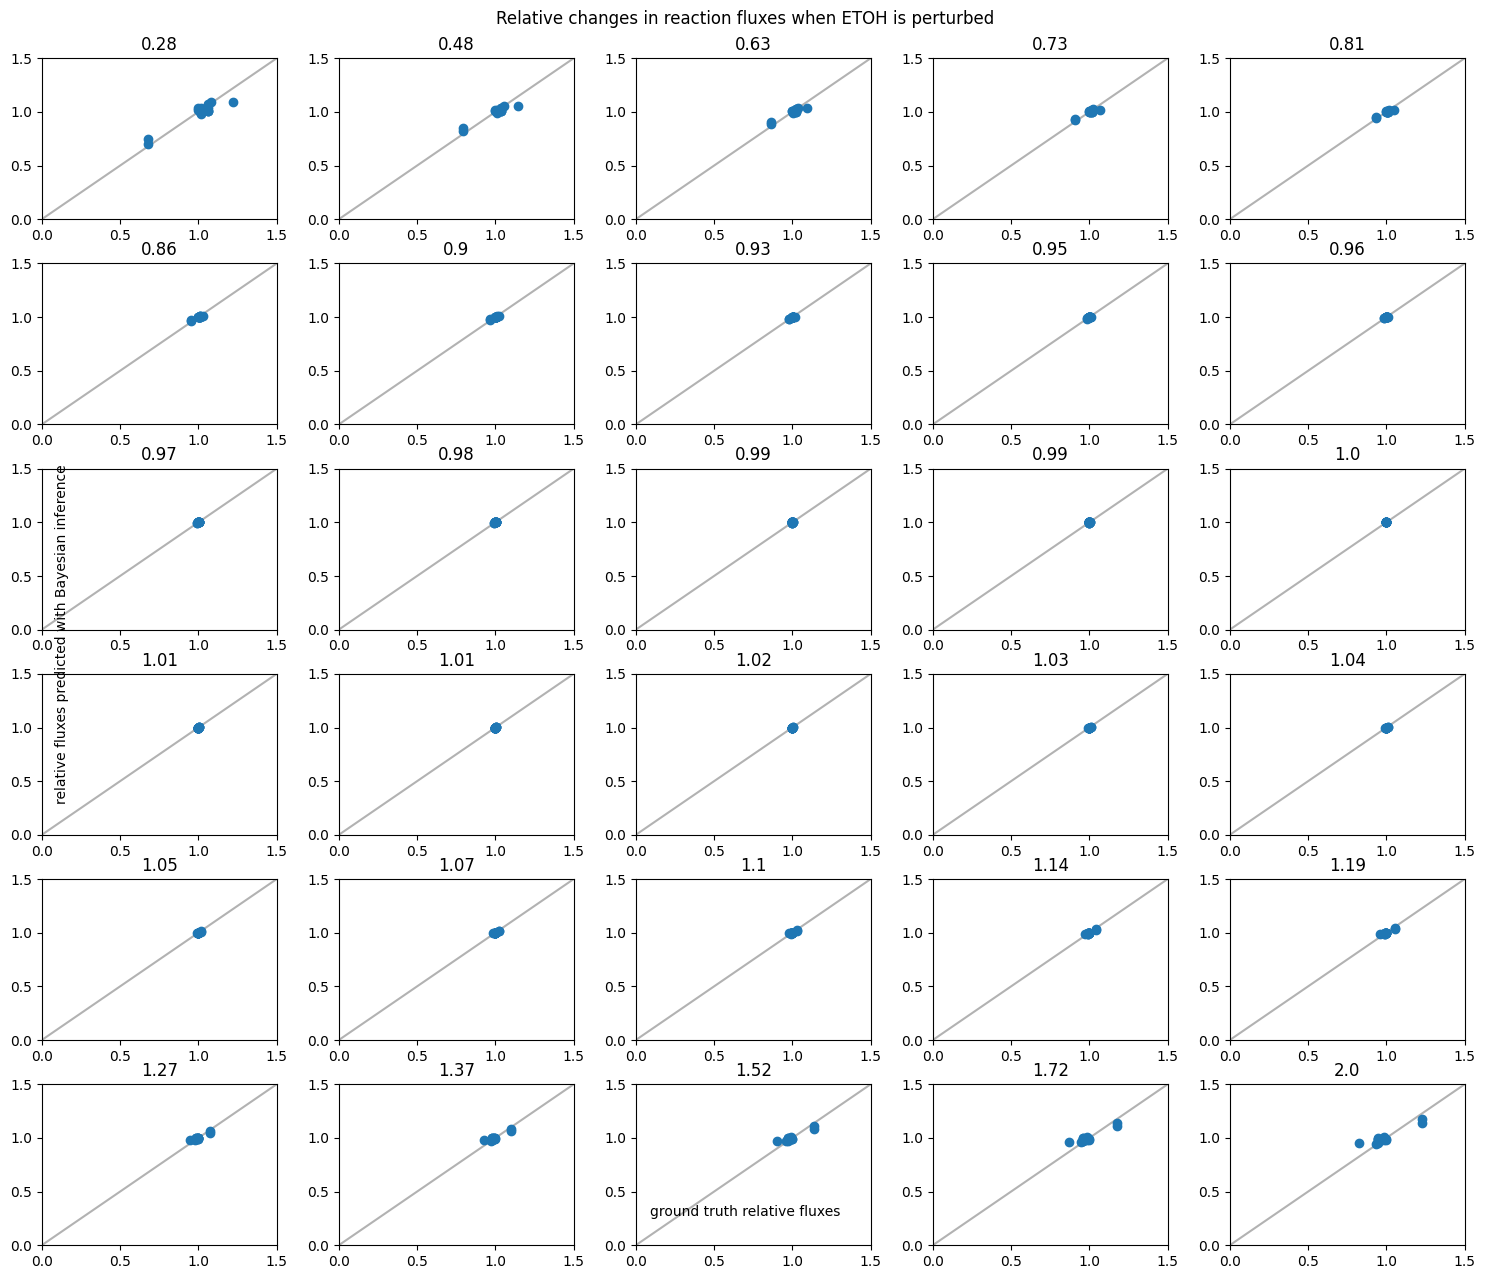

In [40]:
fig, axs = plt.subplots(6,5, figsize=(15, 13)) 
idx_starter = -1

fig.suptitle('Relative changes in reaction fluxes when ETOH is perturbed\n')
fig.tight_layout()

lims = [0,1.5]

for i,col in enumerate(d_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(rel_real_values[col], d_df[col])
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

Text(0, 0.5, 'BayesInf prior values')

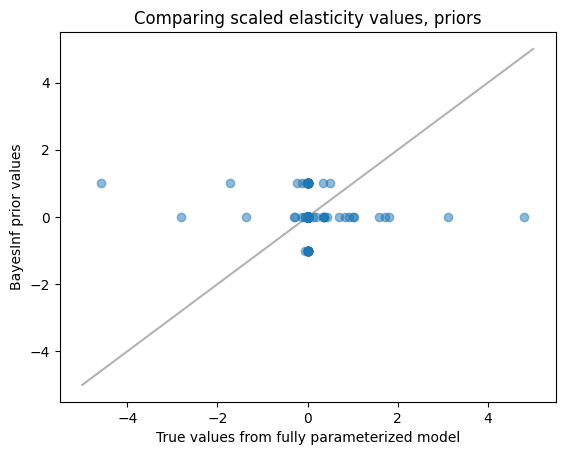

In [42]:
x # the posterior (bayes inf) elasticity values
BIOMD64.Ex # the prior elasticity values
Ex_values = r.getScaledElasticityMatrix()


fig = plt.figure()

plt.scatter(Ex_values, BIOMD64.Ex, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, priors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf prior values')

Text(0, 0.5, 'BayesInf posterior values')

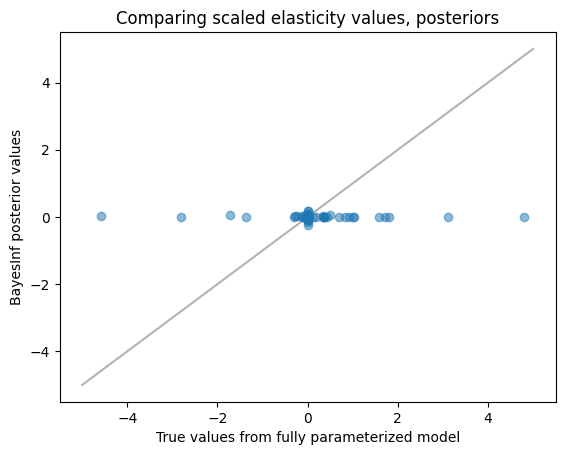

In [43]:
plt.scatter(Ex_values, x, alpha=0.5)
plt.plot([-5,5], [-5,5], 'k-', alpha=0.3, zorder=0)
plt.title('Comparing scaled elasticity values, posteriors')
plt.xlabel('True values from fully parameterized model')
plt.ylabel('BayesInf posterior values')

In [ ]:
import cobra
import os
s = te.loada('data/interim/Antimony/BIOMD0000000064_e_cobra.ant')
with open("temp.txt", "w") as f:
    f.write(s.getSBML())
model = cobra.io.read_sbml_model("temp.txt")
os.remove("temp.txt")

In [8]:
# this cell would belong in the class function
import numpy as np

e_inds = np.array([model.reactions.index(rxn) for rxn in model.reactions])
e_laplace_inds = []
e_zero_inds = []
for i,rxn in enumerate(model.reactions):
    if i not in e_inds:
        if ('e' not in rxn.compartments) and (len(rxn.compartments) == 1):
            e_laplace_inds += [i]
        else:
            e_zero_inds += [i]

e_laplace_inds = np.array(e_laplace_inds)
e_zero_inds = np.array(e_zero_inds)
e_indexer = np.hstack([e_inds, e_laplace_inds, e_zero_inds]).argsort()

In [14]:
import aesara.tensor as at

with pymc_model:
    #Protein Expression Priors
    e_measured = pm.Normal('e_measured', mu=BIOMD64.en, sigma=0.1,
                            shape=(len(BIOMD64.en), len(e_inds)))

    e_unmeasured = pm.Laplace('e_unmeasured', mu=0, b=0.1,
                                shape = (len(BIOMD64.en), len(e_laplace_inds)))

    en_t = at.concatenate(
        [e_measured, e_unmeasured,
        at.zeros((len(BIOMD64.en), len(e_zero_inds)))], axis=1)[:, e_indexer]

    pm.Deterministic('en_t', en_t)

en_t.shape.eval() # 30,17

array([30, 17], dtype=int64)